Imports

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import Sequential

import pathlib

NOTE: This Notebook contains 2 ML models. Model 1 is for identifying the card color, and model 2 is for identifying the card number.

Model 1 Parameters

In [174]:
color_img_height, color_img_width = 300, 300
color_batch_size = 32

# Load images from directory and split into training and validation sets
color_data_dir = pathlib.Path("../colorData")

Model 2 Parameters

In [175]:
num_img_height, num_img_width = 300, 300
num_batch_size = 32

num_data_dir = pathlib.Path("../numberData")

Collecting Data from the data Folders

In [176]:
color_image_count = len(list(color_data_dir.glob('*/*.jpg')))
print(color_image_count)

num_image_count = len(list(num_data_dir.glob('*/*.jpg')))
print(num_image_count)

1350
1348


Model 1 -> Split the Data into Training and Validation Sets

In [177]:
color_train_ds = tf.keras.utils.image_dataset_from_directory(
  color_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(color_img_height, color_img_width),
  batch_size=color_batch_size)

color_val_ds = tf.keras.utils.image_dataset_from_directory(
  color_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(color_img_height, color_img_width),
  batch_size=color_batch_size)

Found 1350 files belonging to 6 classes.
Using 1080 files for training.
Found 1350 files belonging to 6 classes.
Using 270 files for validation.


Model 2 -> Split the Data into Training and Validation Sets

In [178]:
num_train_ds = tf.keras.utils.image_dataset_from_directory(
  num_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(num_img_height, num_img_width),
  batch_size=num_batch_size)

num_val_ds = tf.keras.utils.image_dataset_from_directory(
  num_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(num_img_height, num_img_width),
  batch_size=num_batch_size)

Found 1348 files belonging to 15 classes.
Using 1079 files for training.
Found 1348 files belonging to 15 classes.
Using 269 files for validation.


Model 1 -> Configure the Dataset for Performance

In [179]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = color_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = color_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model 2 -> Configure the dataset for Performance

In [180]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = num_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = num_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Model 1 -> Standardizing the Data

In [181]:
color_normalization_layer = layers.Rescaling(1./255)

Model 1 -> Augmenting the Data
(Generates additional training data from the existing examples by augmenting them using random transformations that yield believable-looking images)

In [182]:
color_data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(color_img_height,
                                  color_img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\Adolf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model 2 -> Standardizing the Data

In [183]:
num_normalization_layer = layers.Rescaling(1./255)

Model 2 -> Augmenting the Data

In [184]:
num_data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(num_img_height,
                                  num_img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Creating Model 1 (Color Model)

Note that this Model has three convolustion blocks (tf.keras.layers.Conv2D) and a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). Dropout is included to prevent overfitting of the model.

In [185]:
color_class_names = color_train_ds.class_names
num_color_classes = len(color_class_names)

color_model = Sequential([
  color_data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_color_classes, name="outputs")
])

Creating Model 2 (Number Model) ; Same Format as Model 1

In [186]:
num_class_names = num_train_ds.class_names
num_num_classes = len(num_class_names)

num_model = Sequential([
  num_data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_num_classes, name="outputs")
])

Model 1 -> Compiling the Model

In [187]:
color_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model 2 -> Compiling the Model

In [188]:
num_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model 1 -> Training

In [189]:
color_epochs = 60

color_history = color_model.fit(
  color_train_ds,
  validation_data=color_val_ds,
  epochs=color_epochs,
)

Epoch 1/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - accuracy: 0.2554 - loss: 4.1997 - val_accuracy: 0.5185 - val_loss: 1.1941
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.6115 - loss: 0.9190 - val_accuracy: 0.6852 - val_loss: 0.8361
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.8306 - loss: 0.4709 - val_accuracy: 0.9074 - val_loss: 0.2982
Epoch 4/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.9097 - loss: 0.2572 - val_accuracy: 0.9741 - val_loss: 0.1491
Epoch 5/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.9385 - loss: 0.1397 - val_accuracy: 0.9926 - val_loss: 0.0883
Epoch 6/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.9843 - loss: 0.0567 - val_accuracy: 0.9815 - val_loss: 0.0802
Epoch 7/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.9872 - loss: 0.0373 - val_accuracy: 0.9815 - val_loss: 0.0794
Epoch 8/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.9910 - loss: 0.0344 - val_accu

Model 2 -> Training

In [ ]:
num_epochs = 200

num_history = num_model.fit(
  num_train_ds,
  validation_data=num_val_ds,
  epochs=num_epochs,
)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.0833 - loss: 21.2228

Model 1 -> Visualizing Training Results

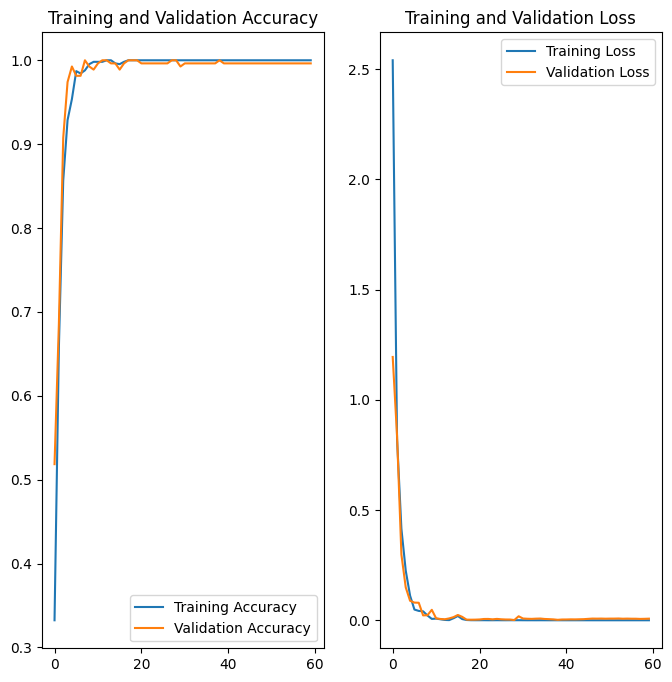

In [191]:
acc = color_history.history['accuracy']
val_acc = color_history.history['val_accuracy']

loss = color_history.history['loss']
val_loss = color_history.history['val_loss']

epochs_range = range(color_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2 -> Visualizing Training Results

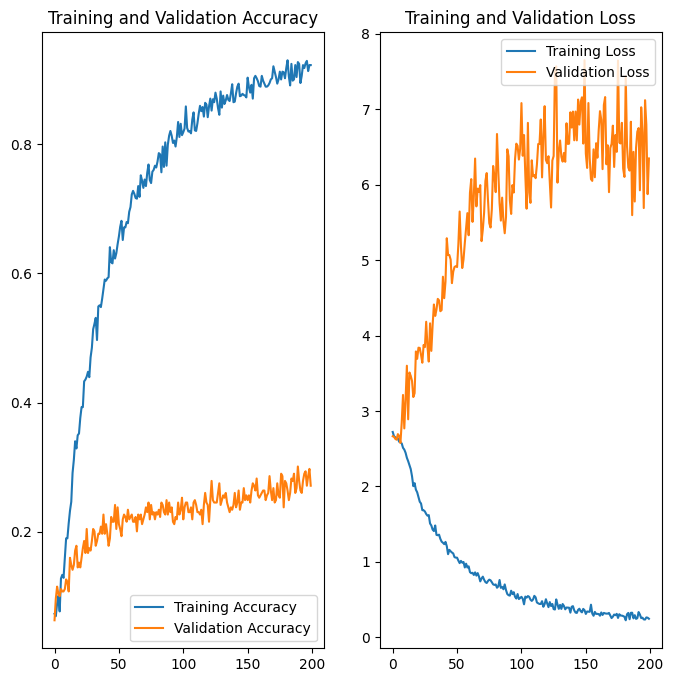

In [192]:
acc = num_history.history['accuracy']
val_acc = num_history.history['val_accuracy']

loss = num_history.history['loss']
val_loss = num_history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing on New Data

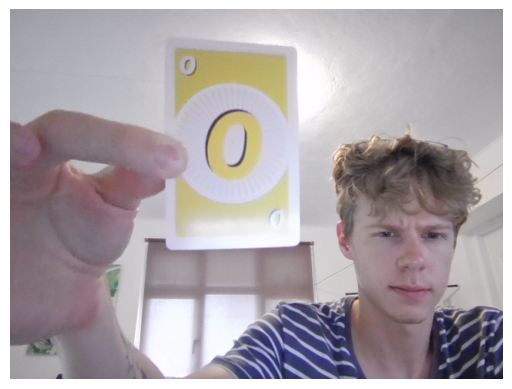

In [193]:
card_path = '../testing_data/y0.jpg'

# Load and display the image
img = plt.imread(card_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

Model 1 -> Predicting on New Data

In [194]:
img = tf.keras.utils.load_img(
    card_path, target_size=(color_img_height, color_img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = color_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(color_class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
This image most likely belongs to green with a 50.83 percent confidence.


Model 2 -> Predicting on New Data

First, we make a quick grayscale copy.

In [195]:
import cv2
import os
# Read the original image
image = cv2.imread(card_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get the original filename and directory
dirname = os.path.dirname(card_path)
basename = os.path.basename(card_path)
filename, ext = os.path.splitext(basename)

# Create a new filename for the grayscale image
gray_image_path = os.path.join(dirname, f"{filename}_grayscale{ext}")

# Save the grayscale image
cv2.imwrite(gray_image_path, gray_image)

print(f"Grayscale image saved at: {gray_image_path}")

Grayscale image saved at: ../testing_data\y0_grayscale.jpg


In [196]:
img = tf.keras.utils.load_img(
    gray_image_path, target_size=(num_img_height, num_img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = num_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(num_class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
This image most likely belongs to 6 with a 100.00 percent confidence.
